# Diplodatos Kaggle Competition
---
Grupo 26

- Alexander Joel Vivas Montolla
- Carlos Barcia
- Nicolas E Ponce
- Sergio Sulca
---

We present this peace of code to create the baseline for the competition, and as an example of how to deal with these kind of problems. The main goals are that you:

1. Learn
1. Try different models and see which one fits the best the given data
1. Get a higher score than the given one in the current baseline example
1. Try to get the highest score in the class :)



Data fields

* `TripType` - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.

* `VisitNumber` - an id corresponding to a single trip by a single customer

* `Weekday` - the weekday of the trip
* `Upc` - the UPC number of the product purchased
* `ScanCount` - the number of the given item that was purchased. A negative value indicates a product return.

* `DepartmentDescription` - a high-level description of the item's department

* `FinelineNumber` - a more refined category for each of the products, created by Walmart

In [1]:
!pip install xgboost

In [2]:
# Import the required packages
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier as DT

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


from scipy.stats import uniform, truncnorm, randint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# variables.
file_path_train = 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/train.csv'
file_path_test = 'https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/practico/data/test.csv'

dtype={
        #'TripType': np.uint8, # unsigned number
        #'VisitNumber': np.uint32,
        #'Weekday': str,
        'Upc': str,
        #'ScanCount': np.int32,
        #'DepartmentDescription': str,
        #'FinelineNumber': str # long
        }

Read the *original* dataset...

In [4]:
original_df = pd.read_csv(file_path_train, dtype=dtype)

original_df.dtypes

TripType                   int64
VisitNumber                int64
Weekday                   object
Upc                       object
ScanCount                  int64
DepartmentDescription     object
FinelineNumber           float64
dtype: object

Looking into the columns values...

**TripType** is the column that we should predict. That column is not present
in the test set.

The min value in `ScanCount` column is `-10`, but a negative value indicates a 
product return. It is posible make a new column using if a values is negative 
or not.

In [6]:
original_df.describe(include='all')

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
count,453411.000000,453411.000000,453411,450559,453411.000000,452439,450559.000000
unique,NaN,NaN,7,84491,NaN,68,NaN
top,NaN,NaN,Sunday,4011.0,NaN,GROCERY DRY GOODS,NaN
freq,NaN,NaN,94602,5355,NaN,49134,NaN
mean,58.027039,95909.846115,NaN,NaN,1.108584,NaN,3727.366554
std,155.973370,55399.801147,NaN,NaN,0.707029,NaN,2779.958546
min,3.000000,5.000000,NaN,NaN,-10.000000,NaN,0.000000
25%,27.000000,49390.000000,NaN,NaN,1.000000,NaN,1404.000000
50%,39.000000,96781.000000,NaN,NaN,1.000000,NaN,3352.000000
75%,40.000000,143930.000000,NaN,NaN,1.000000,NaN,5501.000000


In [7]:
original_df.Weekday.nunique(dropna=False)

7

In [8]:
original_df.DepartmentDescription.nunique(dropna=False)

69

In [9]:
original_df.FinelineNumber.nunique(dropna=False)

5106

In [10]:
original_df.Upc.nunique(dropna=False)

84492

## 1 Pre-processing
---

### 1.1 `NaN` values

There are `nan`s in the column, let us find them...

In [11]:
original_df.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      2852
ScanCount                   0
DepartmentDescription     972
FinelineNumber           2852
dtype: int64

In [12]:
original_df[original_df.DepartmentDescription.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
1292,32,845,Friday,NaN,1,NaN,NaN
1293,32,845,Friday,NaN,1,NaN,NaN
1577,40,1004,Friday,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


When the description is `NaN`, then the Upc and FinelineNumber are both NaN?

In [13]:
(
    original_df.DepartmentDescription.isna().sum(),
    (original_df.DepartmentDescription.isna() & 
     original_df.Upc.isna() & 
     original_df.FinelineNumber.isna()).sum())

(972, 972)

In [14]:
original_df[original_df.Upc.isna()]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
739,999,484,Friday,NaN,-2,NaN,NaN
740,999,484,Friday,NaN,-2,NaN,NaN
900,5,585,Friday,NaN,1,PHARMACY RX,NaN
944,5,619,Friday,NaN,1,PHARMACY RX,NaN
945,5,619,Friday,NaN,1,PHARMACY RX,NaN
...,...,...,...,...,...,...,...
449840,40,190133,Sunday,NaN,1,NaN,NaN
450036,999,190182,Sunday,NaN,-1,NaN,NaN
450163,40,190230,Sunday,NaN,1,NaN,NaN
450361,39,190309,Sunday,NaN,1,NaN,NaN


If `Upc` is `NaN`, then is `NaN` `FileNumber`?

In [15]:
(original_df.Upc.isna().sum(),
 original_df.FinelineNumber.isna().sum(),
 (original_df.FinelineNumber.isna() & original_df.Upc.isna()).sum())

(2852, 2852, 2852)

But it may be the case that both `Upc` and `FineLineNumber` are `NaN` but not the `DepartmentDescription` ...




In [16]:
fil = (original_df.FinelineNumber.isna() & original_df.Upc.isna())
original_df[fil]['DepartmentDescription'].value_counts(dropna=False)

PHARMACY RX    1880
NaN             972
Name: DepartmentDescription, dtype: int64

Despite of previous case, where `Upc` and `FineLineNumber` are `NaN`

`DepartmentDescription` has a value --> `PHARMACY RX`.

36


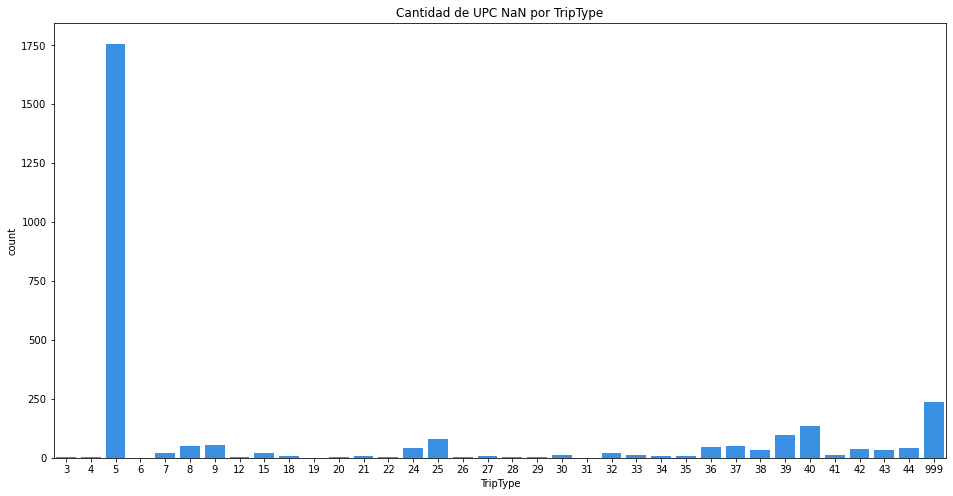

In [17]:
print(original_df[original_df.Upc.isna()].TripType.nunique())

plt.figure(figsize=(16,8))
sns.countplot(
   original_df[original_df.Upc.isna()].TripType, color='dodgerblue')
plt.title('Cantidad de UPC NaN por TripType')
plt.xlabel('TripType')
# plt.ylabel('Cant. de Mediciones')
plt.show()

So, `Upc` and `FinelineNumber` are both `NaN` at the same
time.

### 1.2 Analysis

Our last step in this analysis is to see how balanced is the data...

TripType    38
dtype: int64


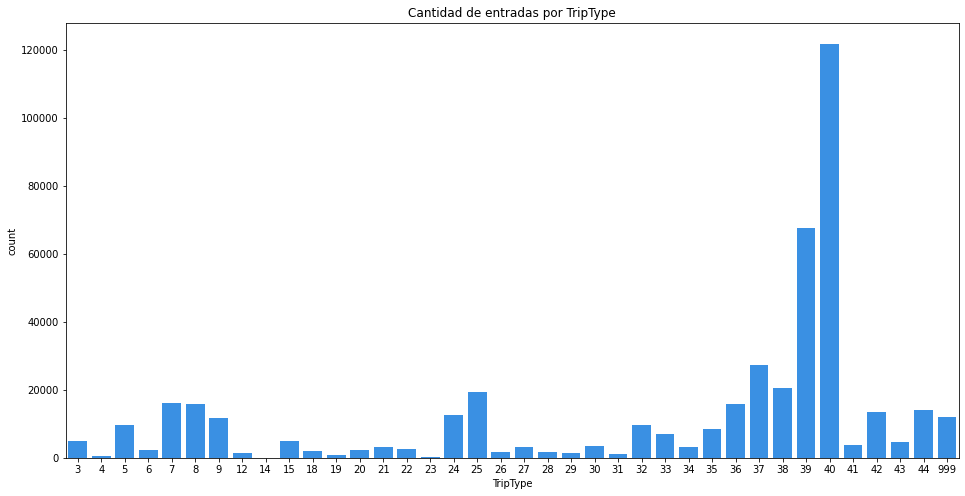

In [19]:
print(original_df[['TripType']].nunique())

plt.figure(figsize=(16,8))
sns.countplot(
    original_df.TripType, color='dodgerblue')
plt.title('Cantidad de entradas por TripType')
plt.xlabel('TripType')
# plt.ylabel('Cant. de Mediciones')
plt.show()

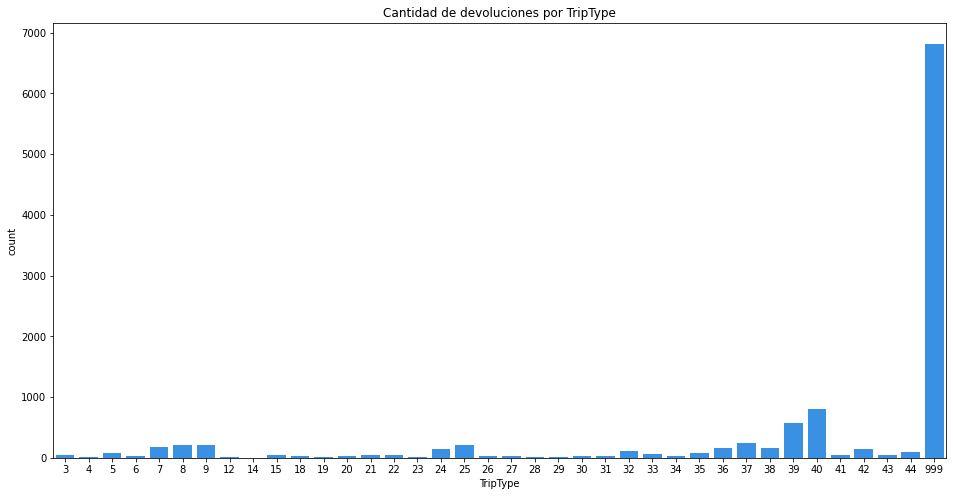

In [20]:
plt.figure(figsize=(16,8))
sns.countplot(
   original_df[original_df.ScanCount < 0].TripType, color='dodgerblue')
plt.title('')
plt.xlabel('TripType')
plt.title('Cantidad de devoluciones por TripType')
# plt.ylabel('Cant. de Mediciones')
plt.show()

In [21]:
del original_df

## 2 Data Cleaning.
---


In [41]:
clean_df = pd.read_csv(file_path_train, dtype=dtype)

### 2.1 Get Labels `TripType`

In [42]:
y = clean_df.groupby(
    ['VisitNumber', 'Weekday'], as_index=False).first().TripType
y

0        999
1          8
2          8
3         35
4         41
        ... 
67024     24
67025     38
67026     25
67027     22
67028      8
Name: TripType, Length: 67029, dtype: int64

### 2.2 Concat Test and Train Dataframes

In [43]:
test_df = pd.read_csv(file_path_test, dtype=dtype)

In [44]:
clean_df = clean_df.drop(['TripType'], axis=1)
clean_df

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,5,Friday,68113152929.0,-1,FINANCIAL SERVICES,1000.0
1,9,Friday,1070080727.0,1,IMPULSE MERCHANDISE,115.0
2,9,Friday,3107.0,1,PRODUCE,103.0
3,9,Friday,4011.0,1,PRODUCE,5501.0
4,10,Friday,6414410235.0,1,DSD GROCERY,2008.0
...,...,...,...,...,...,...
453406,191344,Sunday,73150956660.0,1,BEAUTY,3405.0
453407,191344,Sunday,65053002603.0,1,WIRELESS,1712.0
453408,191344,Sunday,7918131034.0,1,BEAUTY,3405.0
453409,191347,Sunday,4190007664.0,1,DAIRY,1512.0


Set a flag for Training Set and Test Set.

In [45]:
clean_df['is_train_set'] = 1
test_df['is_train_set'] = 0

In [46]:
clean_df = pd.concat([clean_df, test_df])

Delete old test dataframe

In [47]:
del test_df

### 2.3 `nan` values ?

In [48]:
clean_df.isna().sum()

VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
is_train_set                0
dtype: int64

### 2.4 return column

New `return` and `ScanCount` columns from `ScanCount`

`return`

* `1` a return
* `0` no return

In [49]:
def repay_column(df: pd.DataFrame):
    """
    add new return column 
    """
    df['returns'] = df.apply(
        lambda x: abs(x['ScanCount']) if x['ScanCount'] < 0 else 0, axis=1
    )
    return df

In [50]:
clean_df = repay_column(clean_df)
clean_df[['ScanCount', 'returns']]

,ScanCount,returns
0,-1,1
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
193638,1,0
193639,1,0
193640,1,0
193641,1,0


#### Positive ScanCount column

Positive `ScanCount`

In [51]:
clean_df.loc[clean_df.ScanCount < 0, 'ScanCount'] = 0
clean_df

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,is_train_set,returns
0,5,Friday,68113152929.0,0,FINANCIAL SERVICES,1000.0,1,1
1,9,Friday,1070080727.0,1,IMPULSE MERCHANDISE,115.0,1,0
2,9,Friday,3107.0,1,PRODUCE,103.0,1,0
3,9,Friday,4011.0,1,PRODUCE,5501.0,1,0
4,10,Friday,6414410235.0,1,DSD GROCERY,2008.0,1,0
...,...,...,...,...,...,...,...,...
193638,191346,Sunday,3120033013.0,1,DSD GROCERY,4639.0,0,0
193639,191346,Sunday,3700091229.0,1,HOUSEHOLD CHEMICALS/SUPP,8947.0,0,0
193640,191346,Sunday,32390001778.0,1,PHARMACY OTC,1118.0,0,0
193641,191346,Sunday,7874205336.0,1,FROZEN FOODS,1752.0,0,0


### 2.5 `UPC` columns

In its standard version (UPC-A), the bar code consists of a five digit 
manufacturer number and a five digit product number.  In addition there is a
1 digit number system identifier at the start of the code. The number 
system digit denotes the use of one of ten number systems defined by UPC:

* `0, 1 , 6, 7 and 8` are for regular UPC codes.
* `2` is for random weight items, e.g. meat, marked in-store.
* `3` is for National Drug Code and National Health Related Items.
* `4` is for in-store marking of non-food items.
* `5 and 9` are for coupon use.

<p style="text-align: center;">
<img src=http://www.computalabel.com/Images/UPCdiag.png width=75%>
</p>



The UPC symbol also has a `check digit` which is the last digit of the 
code and is calculated according to the algorithm used for EAN.

First step add `0's` to some values in Upc column to clomplete 11 digits

if values is `nan` = `'nan'` (str)

In [52]:
def clean_upc(df):
    
    def f(x):
        if x == '-1' or not isinstance(x, str) :
            x = '-1'
        elif len(x) < 11:
            x = '0' * (11 - len(x)) + x
        return x
    
    df.Upc = df.Upc.str[:-2].apply(f)
    return df

In [53]:
clean_df = clean_upc(clean_df)
clean_df[['Upc']]

,Upc
0,68113152929
1,01070080727
2,00000003107
3,00000004011
4,06414410235
...,...
193638,03120033013
193639,03700091229
193640,32390001778
193641,07874205336


#### numSysChar Column

* `0, 1 , 6, 7 and 8` are for regular UPC codes.
* `2` is for random weight items, e.g. meat, marked in-store.
* `3` is for National Drug Code and National Health Related Items.
* `4` is for in-store marking of non-food items.
* `5 and 9` are for coupon use.

In [54]:
def upc_columns(df):
    df['numSysChar'] = df.apply(
        lambda x: x.Upc[0] if x.Upc != '-1' else '-1', axis=1)
    df['manNum'] = df.apply(
        lambda x: x.Upc[1:6] if x.Upc != '-1' else '-1', axis=1)
    #df['itemNum'] = df.apply(
    #     lambda x: x.Upc[6:11] if x.Upc != '-1' else '-1', axis=1)
    
    # df['checkDig'] = df.apply(
    #     lambda x: int(x.Upc[-1]) if isinstance(x.Upc, str) else -1, axis=1)
    return df

In [56]:
clean_df = upc_columns(clean_df)
clean_df[['Upc', 'numSysChar', 'manNum']]

,Upc,numSysChar,manNum
0,68113152929,6,81131
1,01070080727,0,10700
2,00000003107,0,00000
3,00000004011,0,00000
4,06414410235,0,64144
...,...,...,...
193638,03120033013,0,31200
193639,03700091229,0,37000
193640,32390001778,3,23900
193641,07874205336,0,78742


In [57]:
fil = ['0','1','6','7', '8']
clean_df.loc[clean_df.numSysChar.isin(fil), 'numSysChar'] = 'regular'
fil = ['5','9']
clean_df.loc[clean_df.numSysChar.isin(fil), 'numSysChar'] = 'cupon'

In [58]:
clean_df.numSysChar.value_counts()

regular    612971
3           13892
2           13706
-1           4129
4            1762
cupon         594
Name: numSysChar, dtype: int64

### 2.6 drop columns

In [59]:
clean_df.Upc = clean_df.Upc.astype('float')
clean_df.FinelineNumber = clean_df.FinelineNumber.astype('float')
clean_df.manNum = clean_df.manNum.astype('int')

In [60]:
clean_df

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,is_train_set,returns,numSysChar,manNum
0,5,Friday,6.811315e+10,0,FINANCIAL SERVICES,1000.0,1,1,regular,81131
1,9,Friday,1.070081e+09,1,IMPULSE MERCHANDISE,115.0,1,0,regular,10700
2,9,Friday,3.107000e+03,1,PRODUCE,103.0,1,0,regular,0
3,9,Friday,4.011000e+03,1,PRODUCE,5501.0,1,0,regular,0
4,10,Friday,6.414410e+09,1,DSD GROCERY,2008.0,1,0,regular,64144
...,...,...,...,...,...,...,...,...,...,...
193638,191346,Sunday,3.120033e+09,1,DSD GROCERY,4639.0,0,0,regular,31200
193639,191346,Sunday,3.700091e+09,1,HOUSEHOLD CHEMICALS/SUPP,8947.0,0,0,regular,37000
193640,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0,0,0,3,23900
193641,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0,0,0,regular,78742


### 2.7 Dummies, groupby columns 

Now, we create the dummy columns

In [61]:
clean_df = pd.get_dummies(
    clean_df, 
    columns=['DepartmentDescription'], 
    dummy_na=True)
clean_df

,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber,is_train_set,returns,numSysChar,manNum,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,DepartmentDescription_IMPULSE MERCHANDISE,DepartmentDescription_INFANT APPAREL,DepartmentDescription_INFANT CONSUMABLE HARDLINES,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan
0,5,Friday,6.811315e+10,0,1000.0,1,1,regular,81131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,Friday,1.070081e+09,1,115.0,1,0,regular,10700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,9,Friday,3.107000e+03,1,103.0,1,0,regular,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,9,Friday,4.011000e+03,1,5501.0,1,0,regular,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,10,Friday,6.414410e+09,1,2008.0,1,0,regular,64144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193638,191346,Sunday,3.120033e+09,1,4639.0,0,0,regular,31200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### `numSysChar` Dummies

In [62]:
clean_df = pd.get_dummies(
    clean_df, 
    columns=['numSysChar'], 
    dummy_na=False)
clean_df

,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber,is_train_set,returns,manNum,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,...,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan,numSysChar_-1,numSysChar_2,numSysChar_3,numSysChar_4,numSysChar_cupon,numSysChar_regular
0,5,Friday,6.811315e+10,0,1000.0,1,1,81131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,9,Friday,1.070081e+09,1,115.0,1,0,10700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,9,Friday,3.107000e+03,1,103.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9,Friday,4.011000e+03,1,5501.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,10,Friday,6.414410e+09,1,2008.0,1,0,64144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193638,191346,Sunday,3.120033e+09,1,4639.0,0,0,31200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,.

#### group by VisitNumber and Weekday  
Now, we group by the VisitNumber and Weekday (they should be the same), 
and add all values for ScanCount, and the one-hot encoding 
of `DepartmentDescriptioin`

In [63]:
clean_df = clean_df.groupby(['VisitNumber', 'Weekday'], as_index=False).sum()

In [64]:
clean_df

,VisitNumber,Weekday,Upc,ScanCount,FinelineNumber,is_train_set,returns,manNum,DepartmentDescription_1-HR PHOTO,DepartmentDescription_ACCESSORIES,DepartmentDescription_AUTOMOTIVE,DepartmentDescription_BAKERY,DepartmentDescription_BATH AND SHOWER,DepartmentDescription_BEAUTY,DepartmentDescription_BEDDING,DepartmentDescription_BOOKS AND MAGAZINES,DepartmentDescription_BOYS WEAR,DepartmentDescription_BRAS & SHAPEWEAR,DepartmentDescription_CAMERAS AND SUPPLIES,"DepartmentDescription_CANDY, TOBACCO, COOKIES",DepartmentDescription_CELEBRATION,DepartmentDescription_COMM BREAD,DepartmentDescription_CONCEPT STORES,DepartmentDescription_COOK AND DINE,DepartmentDescription_DAIRY,DepartmentDescription_DSD GROCERY,DepartmentDescription_ELECTRONICS,DepartmentDescription_FABRICS AND CRAFTS,DepartmentDescription_FINANCIAL SERVICES,DepartmentDescription_FROZEN FOODS,DepartmentDescription_FURNITURE,"DepartmentDescription_GIRLS WEAR, 4-6X AND 7-14",DepartmentDescription_GROCERY DRY GOODS,DepartmentDescription_HARDWARE,DepartmentDescription_HEALTH AND BEAUTY AIDS,DepartmentDescription_HOME DECOR,DepartmentDescription_HOME MANAGEMENT,DepartmentDescription_HORTICULTURE AND ACCESS,DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP,DepartmentDescription_HOUSEHOLD PAPER GOODS,...,DepartmentDescription_JEWELRY AND SUNGLASSES,DepartmentDescription_LADIES SOCKS,DepartmentDescription_LADIESWEAR,DepartmentDescription_LARGE HOUSEHOLD GOODS,DepartmentDescription_LAWN AND GARDEN,"DepartmentDescription_LIQUOR,WINE,BEER",DepartmentDescription_MEAT - FRESH & FROZEN,DepartmentDescription_MEDIA AND GAMING,DepartmentDescription_MENS WEAR,DepartmentDescription_MENSWEAR,DepartmentDescription_OFFICE SUPPLIES,DepartmentDescription_OPTICAL - FRAMES,DepartmentDescription_OPTICAL - LENSES,DepartmentDescription_OTHER DEPARTMENTS,DepartmentDescription_PAINT AND ACCESSORIES,DepartmentDescription_PERSONAL CARE,DepartmentDescription_PETS AND SUPPLIES,DepartmentDescription_PHARMACY OTC,DepartmentDescription_PHARMACY RX,DepartmentDescription_PLAYERS AND ELECTRONICS,DepartmentDescription_PLUS AND MATERNITY,DepartmentDescription_PRE PACKED DELI,DepartmentDescription_PRODUCE,DepartmentDescription_SEAFOOD,DepartmentDescription_SEASONAL,DepartmentDescription_SERVICE DELI,DepartmentDescription_SHEER HOSIERY,DepartmentDescription_SHOES,DepartmentDescription_SLEEPWEAR/FOUNDATIONS,DepartmentDescription_SPORTING GOODS,DepartmentDescription_SWIMWEAR/OUTERWEAR,DepartmentDescription_TOYS,DepartmentDescription_WIRELESS,DepartmentDescription_nan,numSysChar_-1,numSysChar_2,numSysChar_3,numSysChar_4,numSysChar_cupon,numSysChar_regular
0,5,Friday,6.811315e+10,0,1000.0,1,1,81131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,7,Friday,6.794963e+10,2,13435.0,0,0,79496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
2,8,Friday,4.259239e+11,30,58669.0,0,2,859233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,16,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,20
3,9,Friday,1.070088e+09,3,5719.0,3,0,10700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,10,Friday,1.700927e+10,3,10073.0,3,0,170092,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95669,191343,Sunday,4.516225e+11,9,33991.0,7,0,516223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,

In [65]:
clean_df = pd.get_dummies(clean_df, columns=["Weekday"], dummy_na=False)

### 2.8 spit (trainm, valid) y  test 

In [66]:
df_test = clean_df[clean_df.is_train_set == 0]
clean_df = clean_df[clean_df.is_train_set != 0]

In [67]:
clean_df = clean_df.drop(["is_train_set"], axis=1)
df_test = df_test.drop(["is_train_set"], axis=1)

## 3 Models Train and Test 
---

Load the data...

### Create the model and evaluate it

split training dataset into train and "validation" 
(we won't be using validation set in this example, because of the cross-validation;

but it could be useful for you depending on your approach)

In [68]:
#state = np.random.RandomState(43)
X_train, X_valid, y_train, y_valid = train_test_split(
    clean_df, y, 
    test_size=0.2, 
    random_state=42)

In [69]:
print(X_train.shape, y_train.shape)

(53623, 88) (53623,)


In [70]:
# results dataframe is used to store the computed results
results = pd.DataFrame(columns=('clf', 'best_acc'))

### 3.1 Decision Tree

In [72]:
tree_param = {
    'criterion':('gini', 'entropy'),
    'min_samples_leaf':(1, 2, 5),
    'min_samples_split':(2, 3, 5, 10, 50, 100)}

tree = DT(random_state=42)
tree_clf = GridSearchCV(tree, tree_param, cv=3, scoring='accuracy', n_jobs=4) 
tree_clf.fit(X_train, y_train)
best_tree_clf = tree_clf.best_estimator_

In [79]:
print(f'Best Decision Tree Test accuracy: = {best_tree_clf.score(X_valid, y_valid)}')
print('Best Decision Tree accuracy: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append(
    {'clf': best_tree_clf, 'best_acc': tree_clf.best_score_}, 
    ignore_index=True
    )

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

Best Decision Tree Test accuracy: = 0.6545576607489184
Best Decision Tree accuracy:  0.6395202762252108
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


### 3.2  `RandomForestClassifier`

In [80]:
kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

model_params = {
    'min_samples_split': [2, 3, 4, 6],
    'class_weight': ['balanced'],
    'max_depth': [64, 96, 108, 128],
    'bootstrap': [False],
}

rfor_clf = GridSearchCV(
    rf_model, model_params, cv=kfold, scoring='accuracy', n_jobs=4
)
rfor_clf.fit(X_train, y_train)
best_tree_clf = tree_clf.best_estimator_

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [81]:
print(f'Best Random Forest Test accuracy = {best_tree_clf.score(X_valid, y_valid)}')
print('Best Random Forest accuracy: ', rfor_clf.best_score_)
print(best_tree_clf)
results = results.append(
    {'clf': best_tree_clf, 'best_acc': rfor_clf.best_score_}, 
    ignore_index=True
    )

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

Best Random Forest Test accuracy = 0.6545576607489184
Best Random Forest accuracy:  0.6884545404988507
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
The best classifier so far is: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


### 3.2 `GradientBoostingClassifier` 

In [82]:
kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

parameters = {
    'learning_rate': [0.1],
    'loss': ['deviance'],
    'min_samples_split': [2],
    'max_depth': [3]
}

clf1 = GradientBoostingClassifier(random_state=42, n_estimators=100)
boost_clf1 = GridSearchCV(clf1, parameters, cv=3, scoring='accuracy', n_jobs=4) 

boost_clf1.fit(X_train, y_train)
best_tree_clf = boost_clf1.best_estimator_

In [83]:
print(f'Best Gradient Boosting Test accuracy = {best_tree_clf.score(X_valid, y_valid)}')
print('Best Gradient Boosting accuracy: ', boost_clf1.best_score_)
print(best_tree_clf)
results = results.append(
    {'clf': best_tree_clf, 'best_acc': boost_clf1.best_score_}, 
    ignore_index=True
    )

print('The best classifier so far is: ')
print(results.loc[results['best_acc'].idxmax()]['clf'])

Best Gradient Boosting Test accuracy = 0.705504997762196
Best Gradient Boosting accuracy:  0.6470169330874266
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
The best classifier so far is: 
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
         

#### 3.3 `XGradientBoostingClassifier` (XGBClassifier)

In [84]:
kfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

xgbc = XGBClassifier(random_state=42)
parameters = {
    'eta': [0.1],
}
xgbc_clf = GridSearchCV(
    xgbc, parameters, cv=kfold, scoring='balanced_accuracy', n_jobs=4)

xgbc_clf.fit(X_train, y_train)
best_tree_clf = xgbc_clf.best_estimator_

In [85]:
best_tree_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [86]:
y_pred = best_tree_clf.predict(X_valid)
predictions = [value for value in y_pred]

accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# print('Best GradientBoostingClassifier: ', best_tree_clf.best_score_)

Accuracy: 70.05%


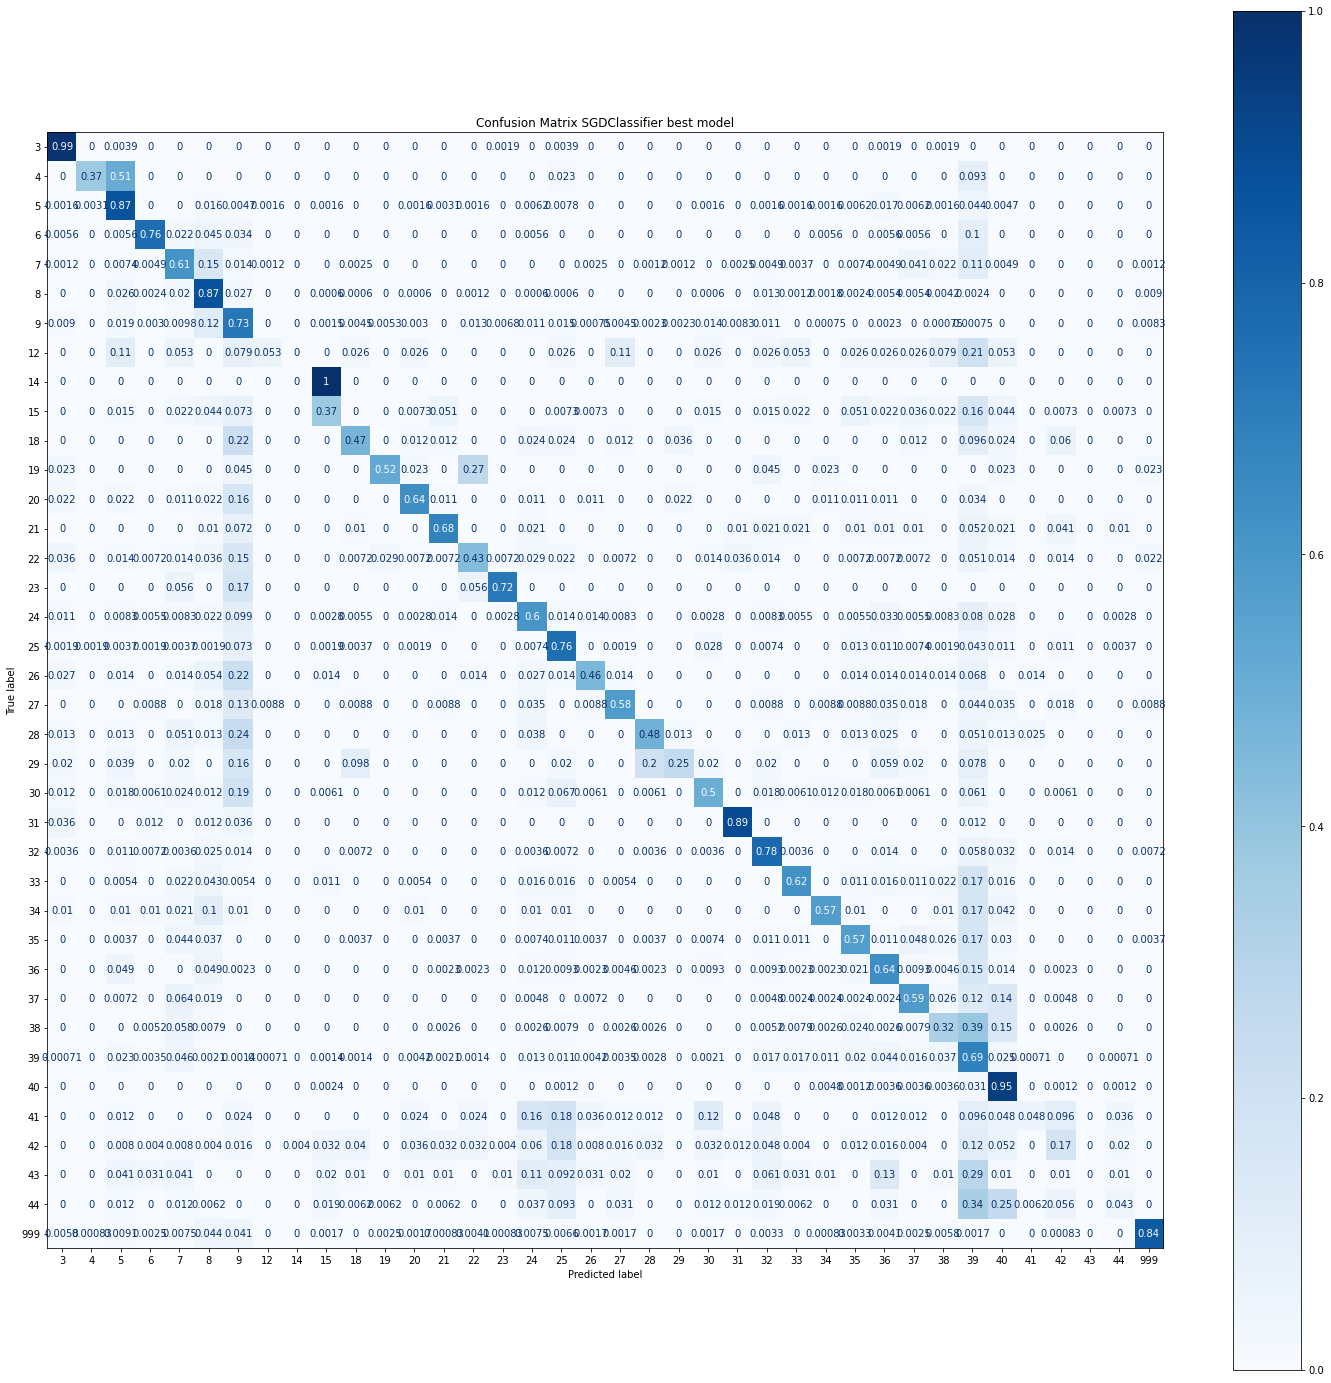

In [88]:
# sns.set_context(context='talk', font_scale=0.5)
fig = plt.figure(figsize=(25,25))
ax = plt.subplot('111')
plot_confusion_matrix(
    best_tree_clf, X_valid, y_valid,
    cmap=plt.cm.Blues,
    normalize='true',
    ax=ax
    )
plt.title('Confusion Matrix SGDClassifier best model')
plt.show()

## 4 Results write back
---

the best model is:
for XGBClassifier Accuracy: `70.05%`

and 



```python
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.100000001, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
```

In [ ]:
# Esto hace un ranking de la importancia de la variable para el modelo
# lo saque de aca https://www.kaggle.com/zlatankr/titanic-random-forest-82-78/data

pd.concat((
    pd.DataFrame(X_train.columns, columns = ['variable']), 
    pd.DataFrame(
        best_tree_clf.feature_importances_, columns = ['importance'])), 
    axis=1
).sort_values(by='importance', ascending=False)[:20]


,variable,importance
2,ScanCount,0.394885
3,FinelineNumber,0.126550
1,Upc,0.076435
24,DepartmentDescription_FINANCIAL SERVICES,0.031606
57,DepartmentDescription_PHARMACY RX,0.025338
21,DepartmentDescription_DSD GROCERY,0.024775
54,DepartmentDescription_PERSONAL CARE,0.024224
47,DepartmentDescription_MENS WEAR,0.018774
61,DepartmentDescription_PRODUCE,0.018364
56,DepartmentDescription_PHARMACY OTC,0.017638


In [ ]:
# yy = results.clf.iloc[0].predict(XX)
best_tree_clf = boost_clf3.best_estimator_
yy = best_tree_clf.predict(df_test)

In [ ]:
submission = pd.DataFrame(
    list(zip(df_test.VisitNumber, yy)), 
    columns=["VisitNumber", "TripType"])

submission

,VisitNumber,TripType
0,7,8
1,8,26
2,15,21
3,19,25
4,23,999
...,...,...
28640,191331,9
28641,191335,32
28642,191342,8
28643,191345,39


In [ ]:
# submission.to_csv("../data/submission.csv", header=True, index=False)

---
## End